Testing Python packages to calculate cross-spectra and theoretical cross-spectra:

- NaMaster
- CCL

## NaMaster

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Import the NaMaster python wrapper
import pymaster as nmt

Binning function from Sukhdeep

In [2]:
import itertools 

def bin_mat(r=[],mat=[],r_bins=[]):#works for cov and skewness
    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

First, define function needed to convert map from Equatorial to Galactic frame.

In [3]:
#From https://stackoverflow.com/questions/44443498/how-to-convert-and-save-healpy-map-to-different-coordinate-system
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

Load map.

In [4]:
#load elg and random file
elgCat = np.load("elg_gal1024.npy")
randomCat = np.load("elg_ran1024.npy")

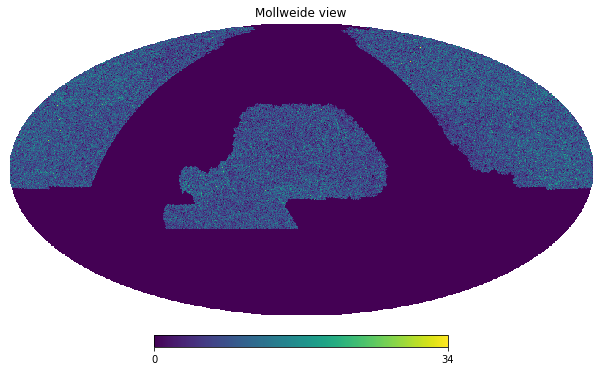

In [5]:
#view elg dist in eq. coord sys
hp.mollview(elgCat)

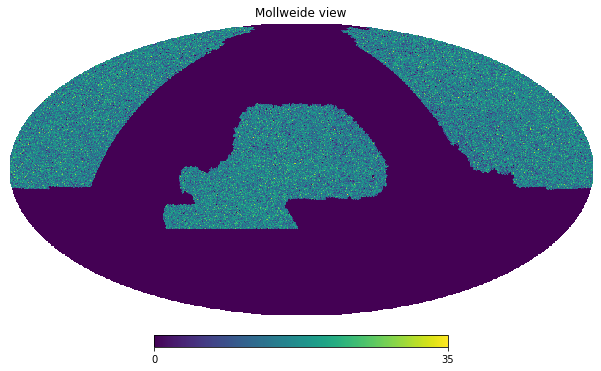

In [6]:
#view elg dist in eq. coord sys
hp.mollview(randomCat)

Note that pixels with $0$ value are a part of the mask. We can verify this by looking at the ratio of the total number of pixels that have ELGs vs. total number of pixels in the map. This represents what fraction of the sky Legacy Surveys covered.

In [7]:
elgCat[elgCat != 0].size/elgCat.size

0.383225679397583

Verified that $\sim 38 \%$ of the sky is covered.

Now, we extract the mask which will later be passed to NaMaster for cross-correlation analysis.

In [8]:
#extract mask
mask_elg = hp.mask_good(randomCat, badval=0.)

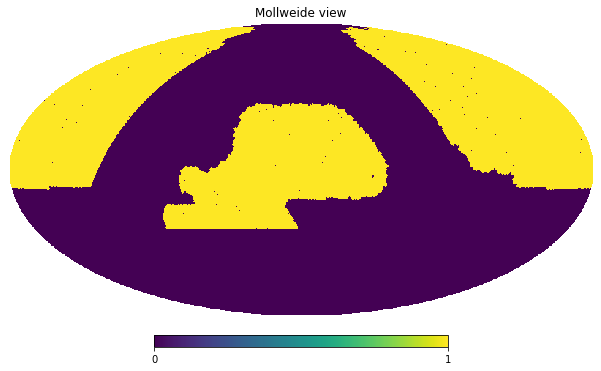

In [9]:
#plot mask
hp.mollview(mask_elg)

Degrade it to nside = 64 for mask apodization

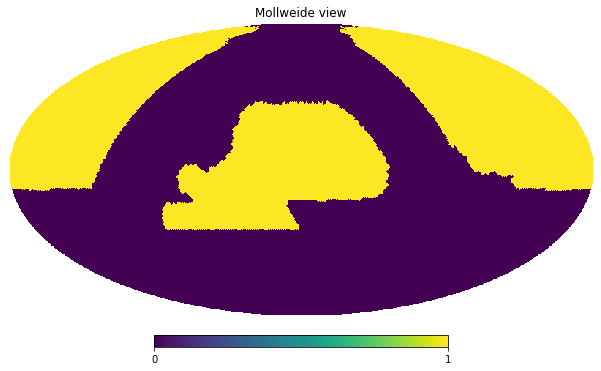

In [10]:
hp.mollview(hp.ud_grade(mask_elg, 64))

In [11]:
#  Simple example showcasing the use of NaMaster to compute the pseudo-Cl
#  estimator of the angular cross-power spectrum of a spin-0 field and a
#  spin-2 field

# HEALPix resolution parameter used here
nside = 1024

# Read mask and apodize it on a scale of ~1deg
#mask_g = nmt.mask_apodization(mask_elg_g, 1., apotype="Smooth")
mask_c = nmt.mask_apodization(hp.ud_grade(mask_elg, 64), 1., apotype="Smooth")

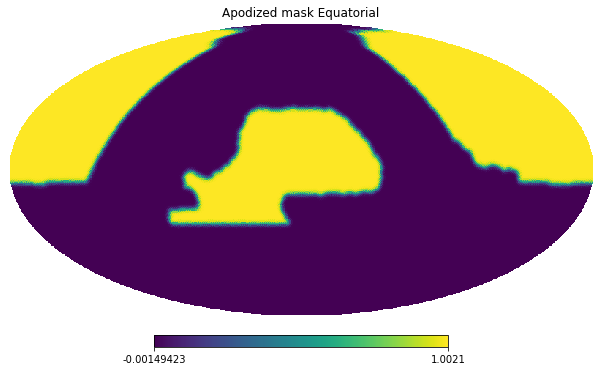

In [12]:
hp.mollview(mask_c, title='Apodized mask Equatorial')
plt.show()

Force apodized mask to yield values between 0 and 1

In [13]:
#force to yield values between 0 and 1
mask_c = np.clip(mask_c, a_min=0, a_max=1)

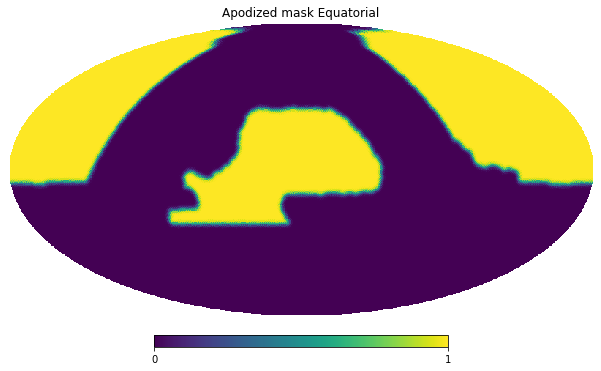

In [14]:
hp.mollview(mask_c, title='Apodized mask Equatorial')
plt.show()

Change resolution back to 1024 to match the original map

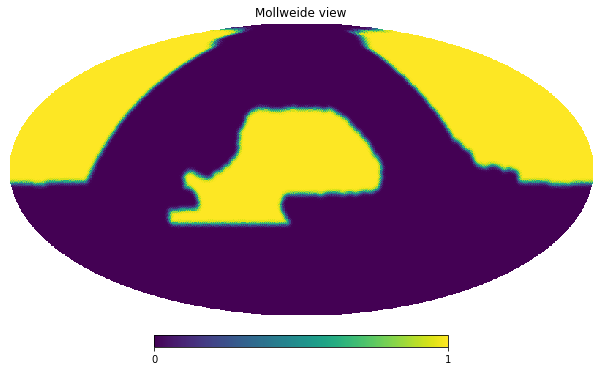

In [14]:
hp.mollview(hp.ud_grade(mask_c, 1024))

#### Read in CMB lensing map and compare with theory

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


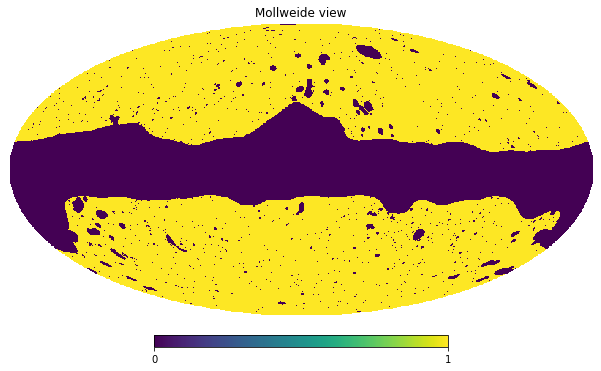

In [3]:
lensingMask = hp.fitsfunc.read_map("lensing/mask.fits")
lensing_mask_bool = lensingMask
hp.mollview(lensingMask)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


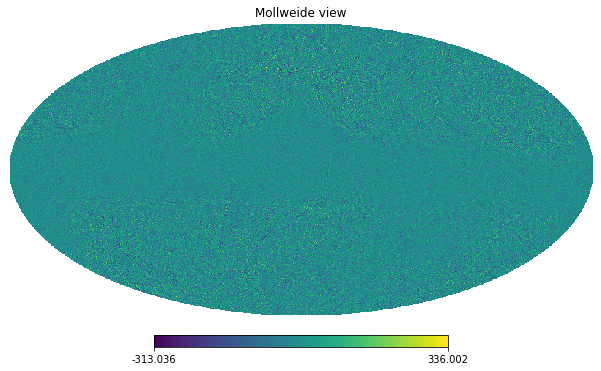

In [4]:
#read in a_lm
almLensing = hp.fitsfunc.read_alm("lensing/MV/dat_klm.fits")
cmbLensing = hp.sphtfunc.alm2map(almLensing, nside = 2048)
hp.mollview(cmbLensing)

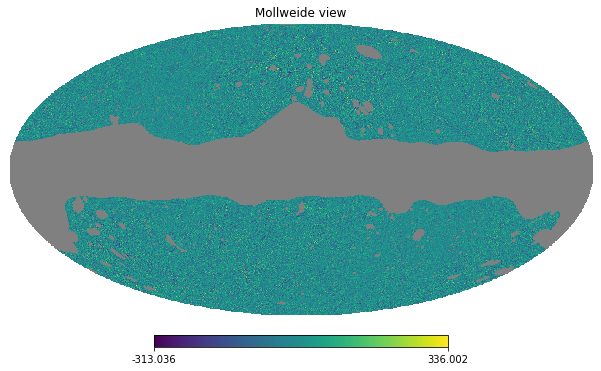

In [5]:
#set mask value to badval 
cmbLensing[lensing_mask_bool == 0] = -1.6375e+30
hp.mollview(cmbLensing)

In [6]:
#calculate ckk_l
lmax = 1500
clkk_planck = hp.sphtfunc.alm2cl(almLensing, lmax_out=lmax)
ell = np.arange(0, lmax+1, 1)

Text(0.5, 1.0, 'Raw convergence power spectrum')

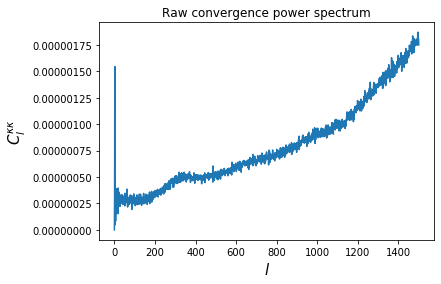

In [7]:
fs = 15

plt.plot(ell, clkk_planck)
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel(r"$C^{\kappa \kappa}_{l}$", fontsize = fs)
plt.title("Raw convergence power spectrum")

Calculate fsky to boost signal

Text(0.5, 1.0, 'Sky-fraction-corrected convergence power spectrum')

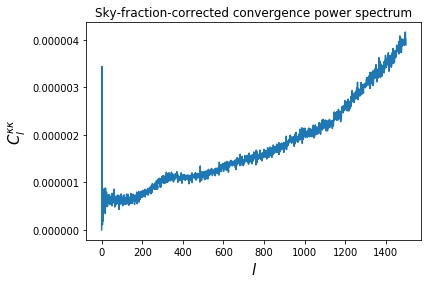

In [9]:
fsky_lensing = lensing_mask_bool.sum()/lensing_mask_bool.size
clkk_planck /= fsky_lensing 

plt.plot(ell, clkk_planck)
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel(r"$C^{\kappa \kappa}_{l}$", fontsize = fs)
plt.title("Sky-fraction-corrected convergence power spectrum")

Remove $n^{\kappa \kappa}_{l}$ from the convergence power spectrum

In [22]:
nlkk_planck = np.genfromtxt("lensing/MV/nlkk.dat")
#nlkk_planck = np.copy(nlkk_planck[:,2][:lmax+1])
clkk_planck_denoised = clkk_planck - nlkk_planck[:,2][:lmax+1]

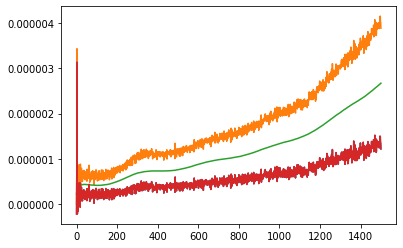

In [25]:
plt.plot(ell, clkk_planck_denoised)
plt.plot(ell, clkk_planck)
plt.plot(ell, nlkk_planck[:,2][:lmax+1])
plt.plot(ell, clkk_planck - nlkk_planck[:,2][:lmax+1])

(9.291576597084916e-08, 8.299447725225379e-07)

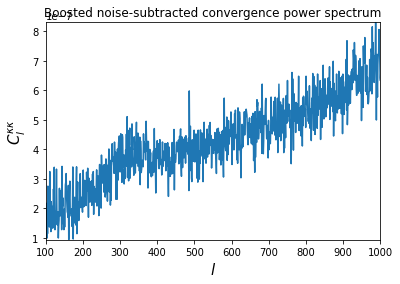

In [14]:
plt.plot(ell, clkk_planck_denoised)
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel(r"$C^{\kappa \kappa}_{l}$", fontsize = fs)
plt.title("Boosted noise-subtracted convergence power spectrum")
plt.xlim(100, 1000)
plt.ylim(clkk_planck_denoised[(ell > 100) & (ell <= 1000)].min(), \
         clkk_planck_denoised[(ell > 100) & (ell <= 1000)].max())

Bin data $L = \Delta l = 100 l$

In [15]:
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(ell, clkk_planck_denoised, ELL)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [16]:
tmp

(array([  50.,  150.,  250.,  350.,  450.,  550.,  650.,  750.,  850.,
         950., 1050., 1150., 1250., 1350., 1450.]),
 array([2.04784572e-07, 2.03834249e-07, 3.01397276e-07, 3.75889441e-07,
        3.81428705e-07, 4.13063770e-07, 4.64352627e-07, 5.03518143e-07,
        5.61472810e-07, 6.49327474e-07, 6.97769120e-07, 7.78723726e-07,
        9.46433933e-07, 1.09009740e-06, 1.25229060e-06]))

Remove $L <= 100$

In [17]:
fltr = (tmp[0] > 100)
ELL_planck = tmp[0][fltr]
cLkk_planck = tmp[1][fltr]

Text(0, 0.5, '$C^{\\kappa \\kappa}_{L}$')

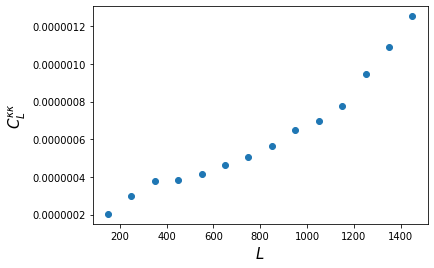

In [18]:
fs = 15

plt.plot(ELL_planck, cLkk_planck, marker = "o", ls = "")
plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$C^{\kappa \kappa}_{L}$", fontsize = fs)

In [26]:
import pyccl as ccl

#define cosmology
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)

In [27]:
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
cls_cmb = ccl.angular_cl(cosmo, cmbl, cmbl, ell)

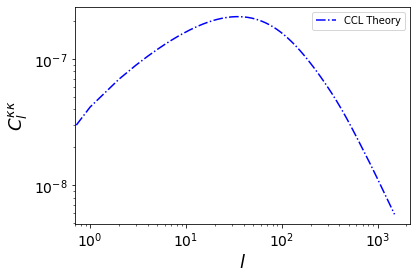

In [28]:
plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C^{\kappa \kappa}_{l}$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_cmb, 'b-.', label = 'CCL Theory')
plt.legend(loc = 'best')
plt.show()

In [29]:
#bin theory data 
ELL = np.arange(0, lmax+1, 100)
clkk_th_binned = bin_mat(ell, cls_cmb, ELL)

#remove L <= 100
fltr = (clkk_th_binned[0] > 100)
ELL_th = clkk_th_binned[0][fltr]
cLkk_th = clkk_th_binned[1][fltr]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


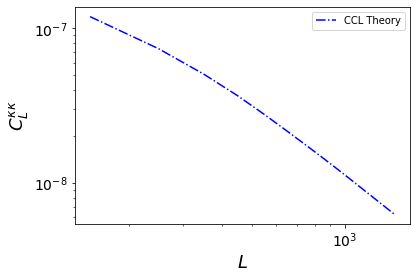

In [30]:
plt.xlabel('$L$',fontsize=18)
plt.ylabel('$C^{\kappa \kappa}_{L}$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ELL_th, cLkk_th, 'b-.', label = 'CCL Theory')
plt.legend(loc = 'best')
plt.show()

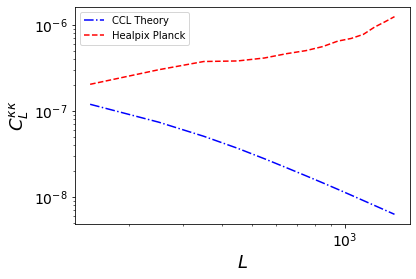

In [31]:
plt.xlabel('$L$',fontsize=18)
plt.ylabel('$C^{\kappa \kappa}_{L}$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ELL_th, cLkk_th, 'b-.', label = 'CCL Theory')
plt.plot(ELL_planck, cLkk_planck, "r--", label = "Healpix Planck")
plt.legend(loc = 'best')
plt.show()

In [82]:
# Read healpix maps and initialize a spin-0 and spin-2 field
f_0 = nmt.NmtField(hp.ud_grade(mask_c, 1024), [elgCat])

# Initialize binning scheme with 100 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 100)

# Compute MASTER estimator
# spin-0 x spin-0
cl_00 = nmt.compute_full_master(f_0, f_0, b)

Check to see the map created after applying apodization

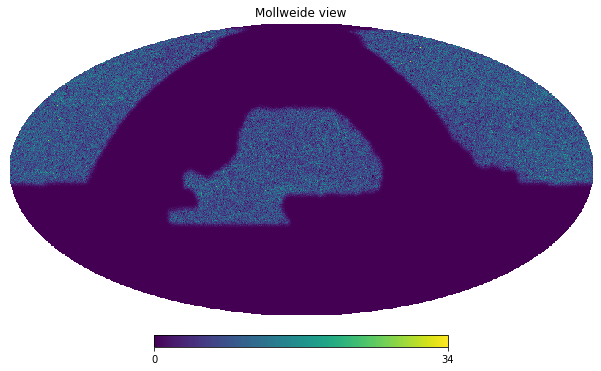

In [83]:
hp.mollview(f_0.get_maps()[0])

In [84]:
cl_00[0]

array([ 7.13147087e-01, -6.90297028e-03,  1.15174350e-04,  8.38672665e-06,
        9.84184185e-06,  2.05791712e-05,  1.84344322e-05,  1.46397419e-05,
        1.36186624e-05,  1.42154211e-05,  1.35644794e-05,  1.25010740e-05,
        1.23627246e-05,  1.23131525e-05,  1.18959373e-05,  1.10169481e-05,
        1.08876338e-05,  1.10137735e-05,  1.08534796e-05,  1.04619928e-05,
        1.04938689e-05,  1.05821871e-05,  1.03101278e-05,  9.97543196e-06,
        9.76115813e-06,  9.67439199e-06,  9.45954340e-06,  9.32389654e-06,
        9.28712480e-06,  9.40487865e-06])

Get binned $L$ values

In [85]:
ell_effective = b.get_effective_ells()

In [86]:
ell_effective

array([  51.5,  151.5,  251.5,  351.5,  451.5,  551.5,  651.5,  751.5,
        851.5,  951.5, 1051.5, 1151.5, 1251.5, 1351.5, 1451.5, 1551.5,
       1651.5, 1751.5, 1851.5, 1951.5, 2051.5, 2151.5, 2251.5, 2351.5,
       2451.5, 2551.5, 2651.5, 2751.5, 2851.5, 2951.5])

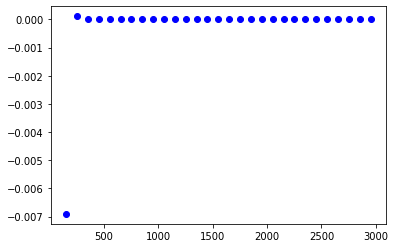

In [37]:
lmin = 100
plt.plot(ell_effective[ell_effective >= lmin], cl_00[0][ell_effective >= lmin], 'bo')

Calculate $C_l$ from healpy

In [39]:
cl_hp_c = hp.anafast(elgCat, elgCat, lmax = 1500)

In [40]:
ell = np.arange(0, 1501, 1)

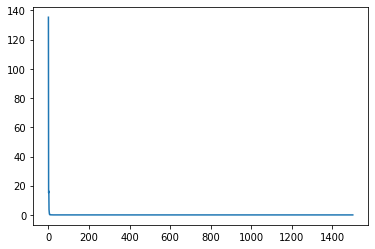

In [41]:
plt.plot(ell, cl_hp_c)

In [42]:
ell_r = np.arange(0, 1501, 100)
ell_r

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500])

In [43]:
cl_hp_binned = bin_mat(ell, cl_hp_c, ell_r)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [44]:
cl_hp_binned

(array([  50.,  150.,  250.,  350.,  450.,  550.,  650.,  750.,  850.,
         950., 1050., 1150., 1250., 1350., 1450.]),
 array([1.80575134e-02, 8.45050724e-05, 2.86153615e-05, 1.62760015e-05,
        1.16682817e-05, 9.02425375e-06, 7.82954067e-06, 6.93602388e-06,
        6.16544748e-06, 5.67220887e-06, 5.40103145e-06, 5.19775336e-06,
        5.07623857e-06, 4.81470087e-06, 4.64965651e-06]))

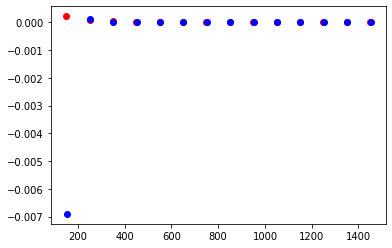

In [70]:
LMAX = 1500
plt.plot(cl_hp_binned[0][cl_hp_binned[0] >= lmin], cl_hp_binned[1][cl_hp_binned[0] >= lmin]/.38, "ro", label = 'Healpy')
plt.plot(ell_effective[(ell_effective >= lmin) & (ell_effective <= LMAX)], \
         cl_00[0][(ell_effective >= lmin) & (ell_effective <= LMAX)], 'bo', label = 'NaMaster')

In [54]:
ell_effective[(ell_effective >= lmin) & (ell_effective <= LMAX)]

array([ 151.5,  251.5,  351.5,  451.5,  551.5,  651.5,  751.5,  851.5,
        951.5, 1051.5, 1151.5, 1251.5, 1351.5, 1451.5])

In [55]:
cl_hp_binned[0][cl_hp_binned[0] >= lmin]

array([ 150.,  250.,  350.,  450.,  550.,  650.,  750.,  850.,  950.,
       1050., 1150., 1250., 1350., 1450.])

Let us look at $\frac{C_{l}^{hp}}{C_{l}^{NM}}$ to see how closely these values agree with each other:

In [76]:
(cl_hp_binned[1][cl_hp_binned[0] >= lmin]/.38)/cl_00[0][(ell_effective >= lmin) & (ell_effective <= LMAX)]

array([-0.03221537,  0.65382251,  5.10706794,  3.11994491,  1.15398409,
        1.11769401,  1.24679073,  1.19136971,  1.05004736,  1.04782795,
        1.09416986,  1.08054842,  1.02900256,  1.02858126])

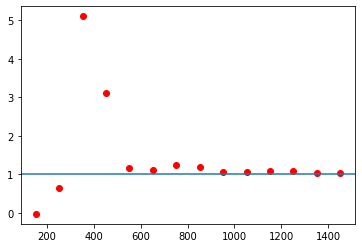

In [89]:
plt.plot(ell_effective[(ell_effective >= lmin) & (ell_effective <= LMAX)], \
        (cl_hp_binned[1][cl_hp_binned[0] >= lmin]/.38)/\
         cl_00[0][(ell_effective >= lmin) & (ell_effective <= LMAX)], 'ro')
plt.axhline(1)

## CCL

### Cross Correlation with galaxy sample

In [58]:
import numpy as np
import pandas as pd
import pylab as plt
import pyccl as ccl

In [59]:
#define cosmology
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)

In [131]:
#read in dNdz
dNdzddeg2 = pd.read_csv("dNdz", sep=" ")

In [132]:
dNdzddeg2

,z,dNdzddeg2
0,0.65,309
1,0.75,2269
2,0.85,1923
3,0.95,2094
4,1.05,1441
5,1.15,1353
6,1.25,1337
7,1.35,523
8,1.45,466
9,1.55,329


Text(0.5, 1.0, 'dNdzddeg^-2 from FDR')

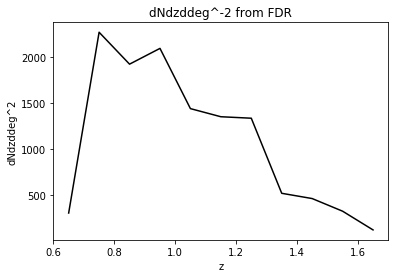

In [133]:
plt.plot(dNdzddeg2['z'], dNdzddeg2['dNdzddeg2'], 'k-')
plt.xlabel("z")
plt.ylabel("dNdzddeg^2")
plt.title("dNdzddeg^-2 from FDR")

In [134]:
z = dNdzddeg2['z']
area = 14000
dNdz = dNdzddeg2['dNdzddeg2']

Text(0.5, 1.0, 'dNdz from FDR')

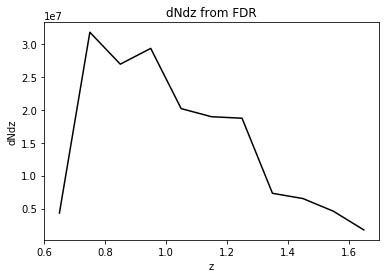

In [135]:
plt.plot(dNdzddeg2['z'], area * dNdzddeg2['dNdzddeg2'], 'k-')
plt.xlabel("z")
plt.ylabel("dNdz")
plt.title("dNdz from FDR")

In [136]:
#set constant bias
b = 1.1*np.ones(len(z))
#bz = np.linspace(1.1, 1.4, len(z)) #linearly increase bias as a function of z

In [137]:
#Create CCL tracer object for galaxy clustering
clu1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))
#clu2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b+0.3))
#clu3 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,bz))

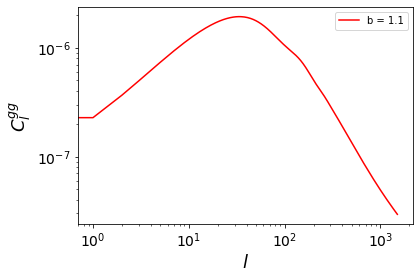

In [138]:
#Calculate angular power spectra of galaxy clustering
ell = np.arange(0, 1500)

cls_clu1 = ccl.angular_cl(cosmo, clu1, clu1, ell) #Clustering with b = 1.1
#cls_clu2 = ccl.angular_cl(cosmo, clu2, clu2, ell) #Clustering with b = 1.4
#cls_clu3 = ccl.angular_cl(cosmo, clu3, clu3, ell) #Clustering with linearly increasing b

plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C^{gg}_{l}$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
#plt.plot(ell, cls, 'k-')
#plt.plot(ell, cls_ia, 'r-')
plt.plot(ell, cls_clu1, 'r-', label = 'b = 1.1')
#plt.plot(ell, cls_clu2, 'k--', label = 'b = 1.4')
#plt.plot(ell, cls_clu3, 'b-.', label = 'b(z)')
#plt.plot(ell, cls_clu1/cls_clu2, label = '$C_l (b = 1.1)/C_l (b = 1.4)$')
plt.legend(loc = 'best')
plt.show()


In [142]:
binned_th = bin_mat(ell, cls_clu1, ell_r)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [173]:
binned_th[0][binned_th[0] >= lmin]

array([ 150.,  250.,  350.,  450.,  550.,  650.,  750.,  850.,  950.,
       1050., 1150., 1250., 1350., 1450.])

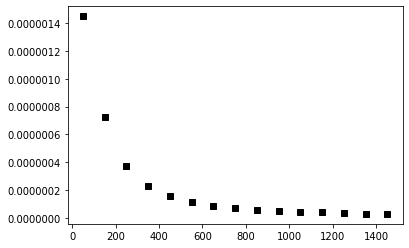

In [144]:
plt.plot(binned_th[0], binned_th[1], 'ks')

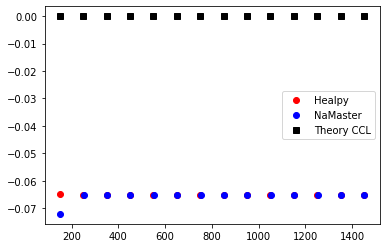

In [172]:
lmin = 100
LMAX = 1500
nbar = np.mean(randomCat[randomCat > 0])
Ngg_l = 1/nbar #shot noise
plt.plot(cl_hp_binned[0][cl_hp_binned[0] >= lmin], cl_hp_binned[1][cl_hp_binned[0] >= lmin]/.38 - Ngg_l,\
         "ro", label = 'Healpy')
plt.plot(ell_effective[(ell_effective >= lmin) & (ell_effective <= LMAX)], \
         cl_00[0][(ell_effective >= lmin) & (ell_effective <= LMAX)] - Ngg_l, 'bo', label = 'NaMaster')
plt.plot(binned_th[0][binned_th[0] >= lmin], binned_th[1][binned_th[0] >= lmin], 'ks', label = "Theory CCL")
plt.legend(loc = 'best')

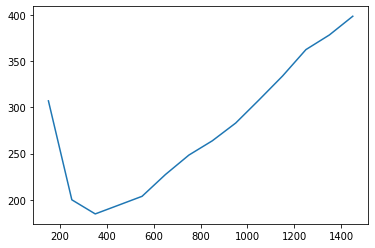

In [176]:
plt.plot(binned_th[0][binned_th[0] >= lmin], (cl_hp_binned[1][cl_hp_binned[0] >= lmin]/.38)/binned_th[1][binned_th[0] >= lmin])

## Checking Cross-Correlation with CMB Lensing

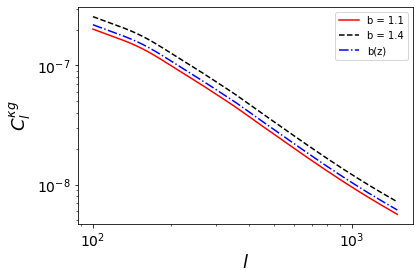

In [27]:
#CMB lensing cross-correlation 
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
cls_cmb_cross_count1 = ccl.angular_cl(cosmo, clu1, cmbl, ell)
cls_cmb_cross_count2 = ccl.angular_cl(cosmo, clu2, cmbl, ell)
cls_cmb_cross_count3 = ccl.angular_cl(cosmo, clu3, cmbl, ell)

plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C^{\kappa g}_{l}$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_cmb_cross_count1, 'r-', label = 'b = 1.1')
plt.plot(ell, cls_cmb_cross_count2, 'k--', label = 'b = 1.4')
plt.plot(ell, cls_cmb_cross_count3, 'b-.', label = 'b(z)')
plt.legend(loc = 'best')
plt.show()

### NaMaster for CMB Lensing

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


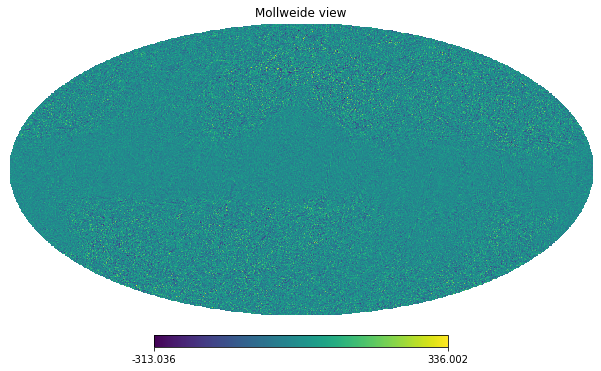

In [2]:
almLensing_planck = hp.fitsfunc.read_alm("data/MV/dat_klm.fits")
lensingMap_planck = hp.sphtfunc.alm2map(almLensing_planck, \
                    nside = 2048, sigma=np.deg2rad(0)) #nside value comes from https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Lensing#2018_Lensing_maps
hp.mollview(lensingMap_planck)

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


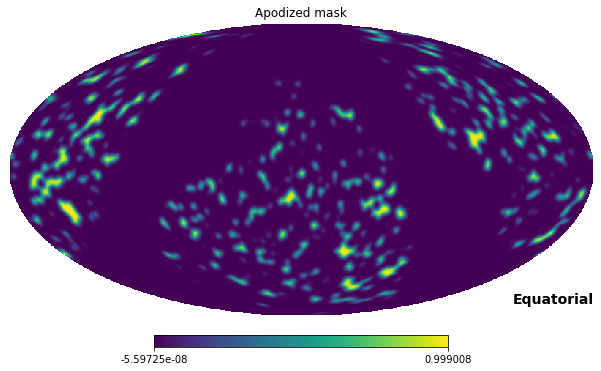

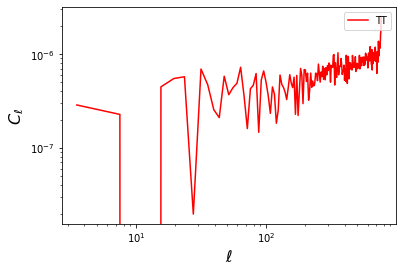

In [3]:
#  Simple example showcasing the use of NaMaster to compute the pseudo-Cl
#  estimator of the angular cross-power spectrum of a spin-0 field and a
#  spin-2 field

# HEALPix resolution parameter used here
nside = 256

# Read mask and apodize it on a scale of ~1deg
mask = nmt.mask_apodization(hp.read_map("data/mask.fits", verbose=False),
                            1., apotype="Smooth")
hp.mollview(mask, coord=['G', 'C'], title='Apodized mask')
plt.show()

# Read healpix maps and initialize a spin-0 and spin-2 field
f_0 = nmt.NmtField(mask, [lensingMap_planck])
#f_2 = nmt.NmtField(mask, hp.read_map("maps.fits", field=[1, 2], verbose=False))

# Initialize binning scheme with 4 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 4)

# Compute MASTER estimator
# spin-0 x spin-0
cl_00 = nmt.compute_full_master(f_0, f_0, b)
# spin-0 x spin-2
#cl_02 = nmt.compute_full_master(f_0, f_2, b)
# spin-2 x spin-2
#cl_22 = nmt.compute_full_master(f_2, f_2, b)

# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_00[0], 'r-', label='TT')
#plt.plot(ell_arr, np.fabs(cl_02[0]), 'g-', label='TE')
#plt.plot(ell_arr, cl_22[0], 'b-', label='EE')
#plt.plot(ell_arr, cl_22[3], 'y-', label='BB')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()